In [ ]:
import os
import zipfile

os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to this folder
!mv kaggle.json /root/.kaggle/kaggle.json


In [ ]:
# set permission
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
# Kaggle dataset download
# download -> zip
# unzip

!kaggle datasets download -d pavansanagapati/images-dataset

Dataset URL: https://www.kaggle.com/datasets/pavansanagapati/images-dataset
License(s): CC0-1.0
 99% 1.01G/1.01G [00:07<00:00, 106MB/s]
100% 1.01G/1.01G [00:07<00:00, 141MB/s]


In [ ]:
# unzip
! unzip images-dataset.zip -d images-dataset

Archive:  images-dataset.zip
  inflating: images-dataset/data/bike/bike_001.bmp  
  inflating: images-dataset/data/bike/bike_002.bmp  
  inflating: images-dataset/data/bike/bike_003.bmp  
  inflating: images-dataset/data/bike/bike_004.bmp  
  inflating: images-dataset/data/bike/bike_005.bmp  
  inflating: images-dataset/data/bike/bike_006.bmp  
  inflating: images-dataset/data/bike/bike_007.bmp  
  inflating: images-dataset/data/bike/bike_008.bmp  
  inflating: images-dataset/data/bike/bike_009.bmp  
  inflating: images-dataset/data/bike/bike_010.bmp  
  inflating: images-dataset/data/bike/bike_011.bmp  
  inflating: images-dataset/data/bike/bike_012.bmp  
  inflating: images-dataset/data/bike/bike_013.bmp  
  inflating: images-dataset/data/bike/bike_014.bmp  
  inflating: images-dataset/data/bike/bike_015.bmp  
  inflating: images-dataset/data/bike/bike_016.bmp  
  inflating: images-dataset/data/bike/bike_017.bmp  
  inflating: images-dataset/data/bike/bike_018.bmp  
  inflating: imag

Epoch 1/10, Train Loss: 2.1353, Val Loss: 1.6983, Val Accuracy: 0.4700
Epoch 2/10, Train Loss: 1.5392, Val Loss: 1.4562, Val Accuracy: 0.5000
Epoch 3/10, Train Loss: 1.3189, Val Loss: 1.5851, Val Accuracy: 0.4700
Epoch 4/10, Train Loss: 1.0935, Val Loss: 1.1918, Val Accuracy: 0.5000
Epoch 5/10, Train Loss: 0.8947, Val Loss: 1.1690, Val Accuracy: 0.5300
Epoch 6/10, Train Loss: 0.6155, Val Loss: 1.0075, Val Accuracy: 0.6400
Epoch 7/10, Train Loss: 0.4623, Val Loss: 1.0945, Val Accuracy: 0.6200
Epoch 8/10, Train Loss: 0.3545, Val Loss: 1.3216, Val Accuracy: 0.5800
Epoch 9/10, Train Loss: 0.2642, Val Loss: 1.2354, Val Accuracy: 0.6100
Epoch 10/10, Train Loss: 0.1533, Val Loss: 1.0870, Val Accuracy: 0.5700


Text(0, 0.5, 'Accuracy')

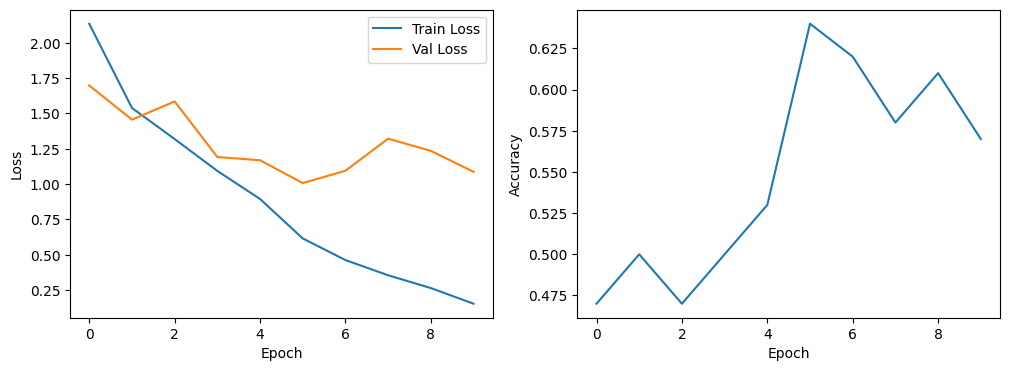

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

DATA_DIR = '/content/images-dataset/data'


torch.manual_seed(42)

image_size = 224


class CustomImageDataset(Dataset):
  def __init__(self, data_dir, transforms=None):
    self.transforms = transforms
    self.samples = []
    self.class_to_idx = {}
    class_folder = sorted(os.listdir(data_dir))
    for idx, class_name in enumerate(class_folder):
      self.class_to_idx[class_name] = idx
      cls_folder = os.path.join(data_dir, class_name)
      for img_name in os.listdir(cls_folder):
        if img_name.endswith(('.jpg', '.jpeg','.png','.bmp')):
          self.samples.append((os.path.join(cls_folder, img_name), idx))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    img_path, label = self.samples[idx]
    img = Image.open(img_path).convert("RGB")
    if self.transforms:
      img = self.transforms(img)
    return img, label

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(), # value between (0,1) , (H, W, C) initial image -> (C, H, W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomImageDataset(DATA_DIR, transforms=transform)

total_len = len(dataset)

val_len = int(total_len * 0.2)

train_len = total_len - val_len

indices = torch.randperm(total_len, generator=torch.Generator().manual_seed(42)).tolist()

train_indices = indices[:train_len]
val_indices = indices[train_len:]

train_dataset = [dataset[i] for i in train_indices]
val_dataset = [dataset[i] for i in val_indices]


train_dataset = train_dataset[:500]
val_dataset = val_dataset[:100]


class SimpleDataset(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    return self.data[idx]


train_dataset = SimpleDataset(train_dataset)
val_dataset = SimpleDataset(val_dataset)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


class CNNModel(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # (3, H, W) -> (32, H, W)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (32, H/2, W/2)

    self.con2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (64, H/2, W/2)
    # self.relu = nn.ReLU()
    # self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (64, H/4, W/4)

    self.con3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # (128, H/4, W/4)
    # self.relu = nn.ReLU()
    # self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # (128, H/8, W/8)

    self.Dropout = nn.Dropout(0.5)

    # fully connected_layer
    feature_map = int(image_size/8)
    self.fc1 = nn.Linear(128*feature_map*feature_map, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    # conv block 1
    x = self.conv1(x)
    x = self.relu(x)
    x = self.pool(x)

    # conv block 2
    x = self.con2(x)
    x = self.relu(x)
    x = self.pool(x)

    # conv block 3
    x = self.con3(x)
    x = self.relu(x)
    x = self.pool(x)

    # flatten
    x = x.view(x.size(0), -1)

    # Fc layer
    x = self.fc1(x)
    x = self.relu(x)
    x = self.Dropout(x)
    x = self.fc2(x)

    return x


num_classes = len(dataset.class_to_idx)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = CNNModel(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 10

for epoch in range(1, num_epochs+1):
  model.train()
  total_train_loss = 0.0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
  train_loss = total_train_loss / len(train_loader)
  train_losses.append(train_loss)


  model.eval()
  correct = 0
  total_val_loss = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()
      preds = outputs.argmax(1)
      correct += (preds == labels).sum().item()
  val_losses.append(total_val_loss/len(val_loader))
  val_accuracies.append(correct/len(val_dataset))



  print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')























































In [ ]:
# Save model
model_path = 'image_cnn.pth'
torch.save(model.state_dict(), model_path)


In [30]:
y = torch.tensor([
    [1,5,2],
    [9,0,3],
    [4,8,7]
])

print(y.argmax(dim=0))

tensor([1, 2, 2])


In [28]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

In [26]:
torch.manual_seed(42)
indices = torch.randperm(10)
indices.tolist()

[2, 6, 1, 8, 4, 5, 0, 9, 3, 7]

In [ ]:
sorted(os.listdir(DATA_DIR))

['bike', 'cars', 'cats', 'data', 'dogs', 'flowers', 'horses', 'human']

In [ ]:
DATA_DIR = '/content/images-dataset/data/bike'
os.listdir(DATA_DIR)

['bike_187.bmp',
 'bike_055.bmp',
 'bike_227.bmp',
 'bike_075.bmp',
 'bike_034.bmp',
 'bike_216.bmp',
 'bike_254.bmp',
 'bike_259.bmp',
 'bike_228.bmp',
 'bike_066.bmp',
 'bike_364.bmp',
 'bike_136.bmp',
 'bike_039.bmp',
 'bike_270.bmp',
 'bike_302.bmp',
 'bike_263.bmp',
 'bike_106.bmp',
 'bike_156.bmp',
 'bike_290.bmp',
 'bike_178.bmp',
 'bike_082.bmp',
 'bike_067.bmp',
 'bike_183.bmp',
 'bike_349.bmp',
 'bike_286.bmp',
 'bike_040.bmp',
 'bike_239.bmp',
 'bike_127.bmp',
 'bike_330.bmp',
 'bike_319.bmp',
 'bike_257.bmp',
 'bike_129.bmp',
 'bike_296.bmp',
 'bike_070.bmp',
 'bike_258.bmp',
 'bike_341.bmp',
 'bike_148.bmp',
 'bike_049.bmp',
 'bike_087.bmp',
 'bike_214.bmp',
 'bike_074.bmp',
 'bike_124.bmp',
 'bike_104.bmp',
 'bike_197.bmp',
 'bike_209.bmp',
 'bike_269.bmp',
 'bike_115.bmp',
 'bike_338.bmp',
 'bike_123.bmp',
 'bike_184.bmp',
 'bike_334.bmp',
 'bike_119.bmp',
 'bike_006.bmp',
 'bike_002.bmp',
 'bike_344.bmp',
 'bike_335.bmp',
 'bike_245.bmp',
 'bike_280.bmp',
 'bike_154.bmp